<a href="https://colab.research.google.com/github/davidegavio/amd-sm2l-project/blob/main/amd_sm2l_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint project AMD - SM2L
Davide Gavio - 930569





# Google Colab settings
Those actions need to be done in order to have the notebook working on Google Colab. 
If the notebook is executed elsewhere skip to the next cell.


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz   
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark pyspark seaborn kaggle scikit-learn matplotlib pandas progressbar2
!rm spark-3.0.1-bin-hadoop2.7.tgz
with open('/content/spark-3.0.1-bin-hadoop2.7/conf/spark-defaults.conf', 'w') as file_object:
  file_object.write('spark.driver.memory              15g')
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

# PySpark settings


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('amd-sm2l-project').master("local[*]").getOrCreate()

# Imports and settings


In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
from matplotlib.pyplot import xlabel, ylabel
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, Row
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, MinMaxScaler, OneHotEncoder, VectorAssembler, StringIndexer, StandardScaler
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LabeledPoint, RidgeRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import ChiSqSelector, VectorIndexer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from zipfile import ZipFile
import os
from datetime import datetime
from pyspark.sql.types import *
import math
import kaggle

In [ ]:
learning_rate = 0.00001
n_iterations = 150
lowest_error = float('inf')
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100, 1000]
alpha = 0.01
num_partitions = spark.sparkContext.defaultParallelism * 3

In [ ]:
print('Parallelism info')
print("Default parallelism: {}".format(spark.sparkContext.defaultParallelism))
print("Custom parallelism: {}\n".format(num_partitions))

Parallelism info
Default parallelism: 2
Custom parallelism: 6



# Ridge Regression


In [ ]:
import numpy as np 
import math
from datetime import datetime
from pyspark.sql import SparkSession
from progressbar import ProgressBar
 
 
 
class SparkRidgeRegression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
        variables X. 
        Parameters:
        -----------
        n_iterations: float
            The number of training iterations the algorithm will tune the weights for.
        learning_rate: float
            The step length that will be used when updating the weights."""
    def __init__(self, n_iterations, learning_rate, reg_factor):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.reg_factor = reg_factor
    
    def get_training_errors(self):
        return self.training_errors
    
    def set_training_errors(self, error):
        self.training_errors = error
 
    def squared_error(self, target, prediction):
        return (target - prediction) ** 2
 
    def root_mean_squared_error(self, predictions):
        return np.sqrt(predictions.map(lambda p: self.squared_error(*p)).mean())
 
    def mean_squared_error(self, predictions):
        return predictions.map(lambda p: self.squared_error(p[0], p[1])).mean()
 
    def mean_absolute_error(self, predictions):
        return np.abs(predictions.map(lambda prediction: prediction[1] - prediction[0]).reduce(lambda a, b: a + b))/predictions.count()
    
    def r2(self, predictions):
        mean_ = predictions.rdd.map(lambda t: t[0]).mean()
        sum_squares = predictions.rdd.map(lambda t: (t[0] - mean_)**2).sum()
        residual_sum_squares = predictions.rdd.map(lambda t: self.squared_error(*t)).sum()
        return 1 - (residual_sum_squares / sum_squares)
 
 
    def get_grad_sum(self, example):
        return (self.weights.dot(DenseVector(example.features)) - example.label) * example.features
 
    
    def fit(self, observations):
        progressbar = ProgressBar()
        features_number = len(observations.take(1)[0].features)
        self.training_errors = []
        self.weights = np.zeros(features_number)        
        start = datetime.now()
        # Do gradient descent for n_iterations
        for i in progressbar(range(self.n_iterations)):
          # Get the prediction given an example and the current weights
          predictions = observations.map(lambda example: self.predict(example)) # Result [label, prediction]
          # Calculate l2 loss
          regularization = self.reg_factor * self.weights
          self.training_errors.append(self.root_mean_squared_error(predictions))
          # Gradient of l2 loss w.r.t w
          grad_w = observations.map(lambda example: DenseVector(self.get_grad_sum(example))).reduce(lambda x, y: x + y) + regularization
          # Update the weights
          self.weights -= self.learning_rate * grad_w
          if i == self.n_iterations-1:
            float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
            predictions_df = float_predictions.toDF(['label', 'predictions'])
            print('From scratch training MSE: {}'.format(self.mean_squared_error(predictions=predictions)))
            print('From scratch training RMSE: {}'.format(self.root_mean_squared_error(predictions=predictions)))
            print('From scratch training MAE: {}'.format(self.mean_absolute_error(predictions=predictions)))
            print('From scratch training R2: {}'.format(self.r2(predictions_df)))
 
    def predict(self, example):
        return (example.label, self.weights.dot(DenseVector(example.features)))

# Utilities

In [ ]:
def to_labeledpoint(row):
  row_dict = row.asDict()
  target = np.array(row_dict['scaled_target'][0])
  features = np.array(row_dict['scaled_features']).tolist()
  features.insert(0, 1.0)
  return LabeledPoint(target, features)
 
def remove_outliers(df):
  quantiles = df.approxQuantile(label_to_predict, [0.25, 0.75], 0.1)
  iqr = quantiles[1] - quantiles[0]
  if iqr != 0:
    df = df.filter(f.col(label_to_predict).between(quantiles[0] - (1.5 * iqr), quantiles[1] + (1.5 * iqr)))
  return df

# Dataset download

In [ ]:
print('Downloading necessary files from Kaggle')
startTime = datetime.now()
kaggle.api.authenticate()
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!mkdir ./datasets
!kaggle datasets download census/2013-american-community-survey -p ./datasets
with ZipFile('./datasets/2013-american-community-survey.zip', 'r') as zipObj:
   zipObj.extractall('./datasets/2013-american-community-survey')
os.remove('./datasets/2013-american-community-survey.zip')
print('Your download has been completed in: {}'.format(datetime.now() - startTime))

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘./datasets’: File exists
100% 916M/916M [00:05<00:00, 182MB/s]
100% 916M/916M [00:06<00:00, 159MB/s]
Your download has been completed in: 0:01:07.948706


# Preprocessing

In [ ]:
%%time
print('Reading from csv')
df_a = spark.read.csv('/content/datasets/2013-american-community-survey/ss13pusa.csv', inferSchema=True, header=True).limit(35000)
# df_a = df_a.sample(False, 0.075, 6)
df_b = spark.read.csv('/content/datasets/2013-american-community-survey/ss13pusb.csv', inferSchema=True, header=True).limit(35000)
# df_b = df_b.sample(False, 0.075, 6)
df = df_a.union(df_b)
df = df.repartition(numPartitions=num_partitions)
label_to_predict = 'WAGP'
drop_thresh = .66
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('The dataframe is divided in {} partitions'.format(df.rdd.getNumPartitions()))
print('==> Done\n')

Reading from csv
The shape is 70000 rows by 283 columns.
The dataframe is divided in 6 partitions
==> Done

CPU times: user 237 ms, sys: 48.6 ms, total: 286 ms
Wall time: 2min 8s


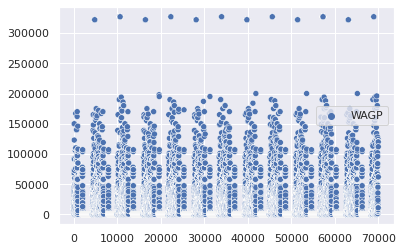

In [ ]:
sn.set_theme(style="darkgrid")
# sn.displot(data=df.select(label_to_predict).toPandas(), kde=True)
sn.scatterplot(data=df.select(label_to_predict).toPandas())

In [ ]:
# df.describe().show()

In [ ]:
# df.select(label_to_predict).describe().show()

In [ ]:
%%time
print('Dropping useless columns, columns and rows with more than {}% of null values'.format(drop_thresh*100))
df = df.select(*(f.col(c).cast("float").alias(c) for c in df.columns)) # Casting the dataframe to float
df = df.drop('RT', 'PINCP ', 'PERNP' ) # Removing unnecessary columns
count_before = df.count()
thresh = int(len(df.columns)*drop_thresh)
df = df.dropna(thresh=thresh) # Dropping rows with more than 66% of null values
print('Dropped {} rows with less than {}% of non-null values'.format(count_before-df.count(), drop_thresh*100))
print('Keeping only rows with non-null value in target position')
count_before = df.count()
df = df.filter(df[label_to_predict].isNotNull()) # Keeping only the rows with not-null values in the corresponding label
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
print('Dropped {} rows with with null in {} column'.format(count_before-df.count(), label_to_predict))
count_before = df.count()
col_before = len(df.columns)
over_thresh_col = df.select([(f.count(f.when(f.col(c).isNull(), c))/count_before).alias(c) for c in df.columns])
scheme = df.columns
null_distr = over_thresh_col.collect()[0].asDict().values()
for i in np.where(np.array(list(null_distr)) > ((1 - drop_thresh)))[0]:
  df = df.drop(scheme[i])
print('Dropped {} columns with less than {}% of non-null values'.format(col_before-len(df.columns), drop_thresh*100))
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('==> Done\n')

Dropping useless columns, columns and rows with more than 66.0% of null values
Dropped 0 rows with less than 66.0% of non-null values
Keeping only rows with non-null value in target position
Dropped 11893 rows with with null in WAGP column
Dropped 47 columns with less than 66.0% of non-null values
The shape is 58107 rows by 234 columns.
==> Done

CPU times: user 1.48 s, sys: 378 ms, total: 1.86 s
Wall time: 3min 19s


In [ ]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             58107|
|   mean|20750.508716677854|
| stddev| 37349.73921337099|
|    min|               0.0|
|    max|          327000.0|
+-------+------------------+



In [ ]:
# %%time
# print('Removing outliers')
# df = remove_outliers(df)
# print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")

In [ ]:
%%time
imput_strategy = 'mean'
print('Filling remaining null values with {} of each column'.format(imput_strategy))
imputer = Imputer() # Filling missing values with mean of the column
imputer.setInputCols(df.columns)
imputer.setOutputCols(df.columns)
imputer.setStrategy(imput_strategy)
df = imputer.fit(df).transform(df)
print('==> Done\n')

Filling remaining null values with mean of each column
==> Done

CPU times: user 155 ms, sys: 34.1 ms, total: 189 ms
Wall time: 51.5 s


In [ ]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             58107|
|   mean|20750.508716677854|
| stddev| 37349.73921337099|
|    min|               0.0|
|    max|          327000.0|
+-------+------------------+



In [ ]:
%%time
print('Choosing top features and assembling vectors')
feature_columns = df.columns
feature_columns.remove(label_to_predict)
features_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
feature_selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selected_features", labelCol=label_to_predict)
target_assembler = VectorAssembler(inputCols=[label_to_predict], outputCol='target')
df = Pipeline(stages=[features_assembler, target_assembler, feature_selector]).fit(df).transform(df)
print(f"The shape is {df.count():d} rows by {feature_selector.getNumTopFeatures():d} columns.")
print('==> Done\n')

Choosing top features and assembling vectors
The shape is 58107 rows by 50 columns.
==> Done

CPU times: user 364 ms, sys: 70.3 ms, total: 434 ms
Wall time: 2min 18s


In [ ]:
df.select('selected_features', 'target').show()

+--------------------+----------+
|   selected_features|    target|
+--------------------+----------+
|[1.0,2500.0,1.0,1...|     [0.0]|
|(50,[0,1,2,3,4,5,...|     [0.0]|
|(50,[0,1,2,3,4,5,...| [50000.0]|
|(50,[0,1,2,3,4,5,...|     [0.0]|
|(50,[0,1,2,3,4,5,...|[322000.0]|
|[2.0,2000.0,1.0,6...| [18000.0]|
|(50,[0,1,2,3,4,5,...|  [8000.0]|
|[1.0,400.0,1.0,31...|     [0.0]|
|(50,[0,1,2,3,4,5,...|     [0.0]|
|(50,[0,1,2,3,4,5,...|     [0.0]|
|(50,[0,1,2,3,4,5,...| [24300.0]|
|[3.0,1305.0,1.0,2...|     [0.0]|
|(50,[0,1,2,3,4,5,...|     [0.0]|
|(50,[0,1,2,3,4,5,...| [22800.0]|
|(50,[0,1,2,3,4,5,...| [35000.0]|
|[1.0,500.0,1.0,12...| [11000.0]|
|(50,[0,1,2,3,4,5,...|  [4500.0]|
|(50,[0,1,2,3,4,5,...|[107000.0]|
|[1.0,100.0,1.0,57...|     [0.0]|
|(50,[0,1,2,3,4,5,...|     [0.0]|
+--------------------+----------+
only showing top 20 rows



In [ ]:
%%time
print('Standardizing and splitting the dataset')
to_split_df = df.select('target', 'selected_features')
to_label_train_set, to_label_validation_set, to_label_test_set = to_split_df.randomSplit(weights=[.6, .2, .2], seed=6)
features_standardscaler = StandardScaler(inputCol='selected_features', outputCol='scaled_features', withStd=True, withMean=True)
target_standardscaler = StandardScaler(inputCol='target', outputCol='scaled_target', withStd=True, withMean=True)
model = Pipeline(stages=[features_standardscaler, target_standardscaler]).fit(to_label_train_set)
scaled_training_set = model.transform(to_label_train_set)
scaled_validation_set = model.transform(to_label_validation_set)
scaled_test_set = model.transform(to_label_test_set)

Standardizing and splitting the dataset
CPU times: user 138 ms, sys: 34.5 ms, total: 173 ms
Wall time: 1min 8s


In [ ]:
scaled_training_set.select('scaled_features', 'scaled_target').show()

+--------------------+--------------------+
|     scaled_features|       scaled_target|
+--------------------+--------------------+
|[0.36552958052480...|[-0.5579471229632...|
|[1.42507961045137...|[-0.5579471229632...|
|[1.42507961045137...|[-0.5579471229632...|
|[1.42507961045137...|[-0.5579471229632...|
|[2.48462964037793...|[-0.5579471229632...|
|[-0.6940204494017...|[-0.5579471229632...|
|[-0.6940204494017...|[-0.5579471229632...|
|[-0.6940204494017...|[-0.5579471229632...|
|[-0.6940204494017...|[-0.5579471229632...|
|[-0.6940204494017...|[-0.5579471229632...|
|[-0.6940204494017...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.5579471229632...|
|[0.36552958052480...|[-0.557947

In [ ]:
%%time
print('Creating labeled points')
to_label_train = scaled_training_set.select('scaled_target', 'scaled_features')
to_label_validation = scaled_validation_set.select('scaled_target', 'scaled_features')
to_label_test = scaled_test_set.select('scaled_target', 'scaled_features')
labeled_train_df = to_label_train.rdd.map(lambda row: to_labeledpoint(row))
labeled_validation_df = to_label_validation.rdd.map(lambda row: to_labeledpoint(row))
labeled_test_df = to_label_test.rdd.map(lambda row: to_labeledpoint(row))
labeled_train_df = labeled_train_df.repartition(num_partitions)
labeled_validation_df = labeled_validation_df.repartition(num_partitions)
labeled_test_df = labeled_test_df.repartition(num_partitions)
labeled_train_df.cache()
labeled_validation_df.cache()
labeled_test_df.cache()
print('Training set count: {} divided in {} partitions'.format(labeled_train_df.count(), labeled_train_df.getNumPartitions()))
print('Validation set count: {} divided in {} partitions'.format(labeled_validation_df.count(), labeled_validation_df.getNumPartitions()))
print('Test set count: {} divided in {} partitions'.format(labeled_test_df.count(), labeled_test_df.getNumPartitions()))
print('==> Done\n')

Creating labeled points
Training set count: 34900 divided in 6 partitions
Validation set count: 11553 divided in 6 partitions
Test set count: 11654 divided in 6 partitions
==> Done

CPU times: user 214 ms, sys: 65.8 ms, total: 280 ms
Wall time: 1min 43s


In [ ]:
print('Training and predictions will work on ')
labeled_train_df.take(2)

Training and predictions will work on 


[LabeledPoint(-0.5579471229632581, [1.0,0.36552958052480927,0.2742950904585996,1.0127314705758255,-0.6248089113859319,0.3273255726999342,2.44998300618438,0.22788611271443898,0.25437021792257336,0.204273484181676,0.3058778713938915,0.38370509510504597,0.2853602770230392,0.21657027322110325,-0.9329448652203464,0.4479143329809729,0.6108961505587386,0.3784787086526131,0.20662151825808733,4.276172717528292,-0.8375182884783671,0.1360855988238697,0.17233186048477941,-0.7223211225580194,0.12692708649211623,-0.3938093364984255,0.380289216767227,0.8556709799752377,0.3381621977224929,0.8992735127043328,0.8231696089048076,0.2656173525957214,-0.0634679529025602,-0.2835500396762532,-0.3648696450097845,-0.3922987528664467,0.9574516316415604,-0.7974155825439461,-0.9796321601739854,-1.2467922204423065,-2.314141626688883,0.5193994494567056,-0.9478654890064586,-0.3957045508606749,1.211508199880143,-0.9031016395247891,-0.17980449395395326,-0.19919716678479843,-0.04212251464249852,1.0673557195844896,0.0572

# Best model individuation

In [ ]:
%%time
from progressbar import ProgressBar
progressbar = ProgressBar()
print('Finding regularization factor using grid search')
best_reg_factor = 0
mean_squared_errors = []
for candidate_reg_factor in progressbar(alphas):
  print('Trying using {} as regularization factor'.format(candidate_reg_factor))
  mean_squared_error = 0
  candidate_rr = SparkRidgeRegression(n_iterations=n_iterations, learning_rate=0.00001, reg_factor=candidate_reg_factor)
  candidate_rr.fit(labeled_train_df)
  print('Validating')
  candidate_pred = labeled_validation_df.map(lambda prediction: candidate_rr.predict(prediction))
  mean_squared_error = candidate_rr.mean_squared_error(predictions=candidate_pred)
  mean_squared_errors.append(mean_squared_error)
  if mean_squared_error < lowest_error:
    print('Currently best regularization factor: {}'.format(candidate_reg_factor))
    best_reg_factor = candidate_reg_factor
    lowest_error = mean_squared_error
alpha = best_reg_factor
print('Grid search terminated, chosen regularization factor: {}'.format(best_reg_factor))

N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finding regularization factor using grid search
Trying using 1e-06 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:43 ETA:   0:00:01

From scratch training MSE: 3.008066504534152e+35
From scratch training RMSE: 5.484584309256402e+17
From scratch training MAE: 878.5861318051576


100% (150 of 150) |######################| Elapsed Time: 0:04:52 Time:  0:04:52


From scratch training R2: -3.0081526980211743e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Currently best regularization factor: 1e-06
Trying using 1e-05 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:37 ETA:   0:00:01

From scratch training MSE: 3.0080665658728512e+35
From scratch training RMSE: 5.4845843651755885e+17
From scratch training MAE: 848.7757020057306


100% (150 of 150) |######################| Elapsed Time: 0:04:45 Time:  0:04:45


From scratch training R2: -3.0081527593616307e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 0.0001 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:41 ETA:   0:00:01

From scratch training MSE: 3.008067179260512e+35
From scratch training RMSE: 5.4845849243680346e+17
From scratch training MAE: 898.1859025787966


100% (150 of 150) |######################| Elapsed Time: 0:04:49 Time:  0:04:49


From scratch training R2: -3.0081533727668675e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 0.001 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:38 ETA:   0:00:01

From scratch training MSE: 3.0080733131435766e+35
From scratch training RMSE: 5.4845905162952474e+17
From scratch training MAE: 868.1407449856733


100% (150 of 150) |######################| Elapsed Time: 0:04:47 Time:  0:04:47


From scratch training R2: -3.008159506825701e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 0.01 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:34 ETA:   0:00:01

From scratch training MSE: 3.0081346526600536e+35
From scratch training RMSE: 5.484646435879029e+17
From scratch training MAE: 825.0681948424069


100% (150 of 150) |######################| Elapsed Time: 0:04:43 Time:  0:04:43


From scratch training R2: -3.0082208480998087e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 1 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:33 ETA:   0:00:01

From scratch training MSE: 3.0148896156888855e+35
From scratch training RMSE: 5.490801048744059e+17
From scratch training MAE: 852.5313467048711


100% (150 of 150) |######################| Elapsed Time: 0:04:41 Time:  0:04:41


From scratch training R2: -3.0149760046861273e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 10 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:34 ETA:   0:00:01

From scratch training MSE: 3.0769959761408916e+35
From scratch training RMSE: 5.5470676723300314e+17
From scratch training MAE: 817.9089971346705


100% (150 of 150) |######################| Elapsed Time: 0:04:42 Time:  0:04:42


From scratch training R2: -3.077084144740998e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 100 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:35 ETA:   0:00:01

From scratch training MSE: 3.772669692970055e+35
From scratch training RMSE: 6.142206194007212e+17
From scratch training MAE: 899.3595415472779


100% (150 of 150) |######################| Elapsed Time: 0:04:43 Time:  0:04:43


From scratch training R2: -3.772777795485658e+35
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 1000 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:36 ETA:   0:00:01

From scratch training MSE: 2.874465854184634e+36
From scratch training RMSE: 1.6954249774568717e+18
From scratch training MAE: 2859.453982808023


100% (150 of 150) |######################| Elapsed Time: 0:04:45 Time:  0:04:45


From scratch training R2: -2.8745482194630936e+36
Validating


100% (9 of 9) |##########################| Elapsed Time: 0:42:54 Time:  0:42:54


Grid search terminated, chosen regularization factor: 1e-06
CPU times: user 53.2 s, sys: 4.59 s, total: 57.8 s
Wall time: 42min 54s


MSE with different regularization factors


Text(0, 0.5, 'MSE from 3.003349e+35 to 2.869958e+36')

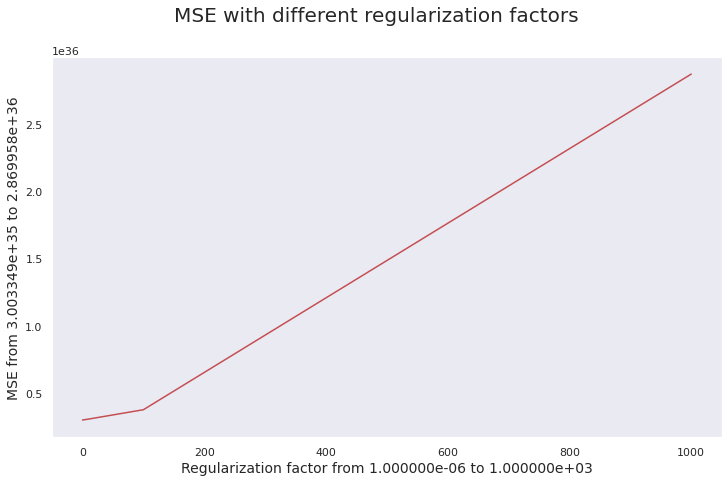

In [ ]:
print('MSE with different regularization factors')
fig = plt.figure(figsize = (12, 7))
g = sn.lineplot(x=alphas, y=mean_squared_errors, color = 'r').grid()
fig.suptitle('MSE with different regularization factors', fontsize = 20)
plt.xlabel('Regularization factor from {:e} to {:e}'.format(min(alphas), max(alphas)), fontsize = 14)
plt.ylabel('MSE from {:e} to {:e}'.format(min(mean_squared_errors), max(mean_squared_errors)), fontsize = 14)
# plt.xticks(alphas, mean_squared_errors)

# Training and evaluation

In [ ]:
%%time
print('Training with {} as learning rate and {} as regularization factor'.format(0.00001, alpha))
spark_rr = SparkRidgeRegression(n_iterations=n_iterations, learning_rate=0.00001, reg_factor=alpha)
now = datetime.now()
spark_rr.fit(labeled_train_df)
print('==> Done in {}\n'.format(datetime.now()-now))

N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training with 1e-05 as learning rate and 1e-06 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:34 ETA:   0:00:01

From scratch training MSE: 3.008066504534152e+35
From scratch training RMSE: 5.484584309256402e+17
From scratch training MAE: 878.5861318051576


100% (150 of 150) |######################| Elapsed Time: 0:04:42 Time:  0:04:42


From scratch training R2: -3.0081526980211743e+35
==> Done in 0:04:42.679103

CPU times: user 5.82 s, sys: 505 ms, total: 6.33 s
Wall time: 4min 42s


In [ ]:
%%time
print('Predicting')
predictions = labeled_test_df.map(lambda prediction: spark_rr.predict(prediction))
float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
predictions_df = float_predictions.toDF(['label', 'predictions'])
print('==> Done\n')

Predicting
==> Done

CPU times: user 26.4 ms, sys: 1.72 ms, total: 28.1 ms
Wall time: 60.7 ms


In [ ]:
%%time
root_mean_squared_error = spark_rr.root_mean_squared_error(predictions=predictions)
mean_squared_error = spark_rr.mean_squared_error(predictions=predictions)
mean_absolute_error = spark_rr.mean_absolute_error(predictions=predictions)
r2_score = spark_rr.r2(predictions_df)
print('From scratch test MSE: {}'.format(mean_squared_error))
print('From scratch test RMSE: {}'.format(root_mean_squared_error))
print('From scratch test MAE: {}'.format(mean_absolute_error))
print('From scratch test R2: {}'.format(r2_score))
print('==> Done\n')

From scratch test MSE: 3.0131107153401775e+35
From scratch test RMSE: 5.4891809182611e+17
From scratch test MAE: 3456267346130641.5
From scratch test R2: -3.027014612247103e+35
==> Done

CPU times: user 114 ms, sys: 9.35 ms, total: 123 ms
Wall time: 2.91 s


Text(0, 0.5, 'Training error')

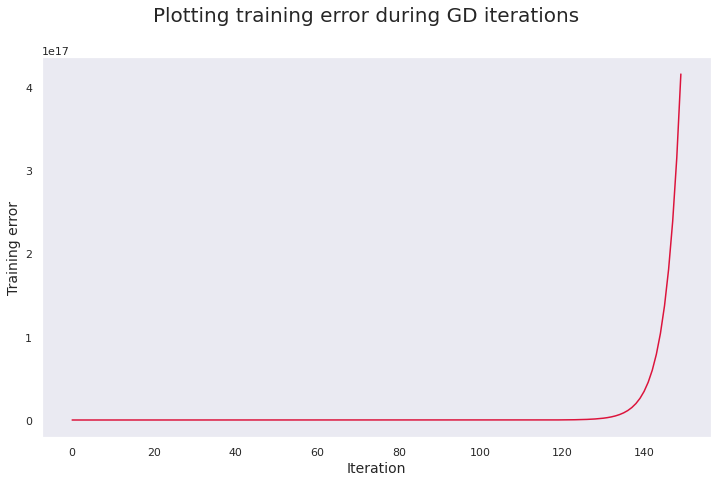

In [ ]:
fig = plt.figure(figsize = (12, 7))
g = sn.lineplot(x = np.arange(spark_rr.n_iterations), y = spark_rr.training_errors, color = 'crimson').grid()
fig.suptitle('Plotting training error during GD iterations', fontsize = 20)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Training error', fontsize = 14)

In [ ]:
x = np.array(predictions_df.select('label').collect()).flatten()
y = np.array(predictions_df.select('predictions').collect()).flatten()
e = [abs(x[i] - y[i]) for i in range(len(x))]
df = pd.DataFrame(list(zip(x, y, e)), columns = ['label', 'prediction', 'error'])
df

,label,prediction,error
0,-0.557947,3.921747e+17,3.921747e+17
1,-0.557947,3.577566e+17,3.577566e+17
2,-0.557947,2.922509e+17,2.922509e+17
3,-0.557947,2.900809e+17,2.900809e+17
4,-0.557947,1.625076e+17,1.625076e+17
...,...,...,...
11649,2.667348,-5.138299e+17,5.138299e+17
11650,2.667348,-5.759759e+17,5.759759e+17
11651,2.667348,-7.124786e+17,7.124786e+17
11652,2.747980,-6.266712e+17,6.266712e+17


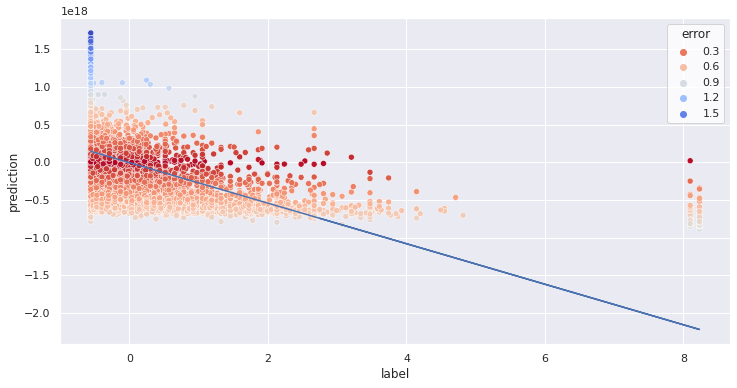

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
m, b = np.polyfit(x, y, 1)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df, x="label", y="prediction", hue='error', palette='coolwarm_r')

plt.plot(x, m*x + b)

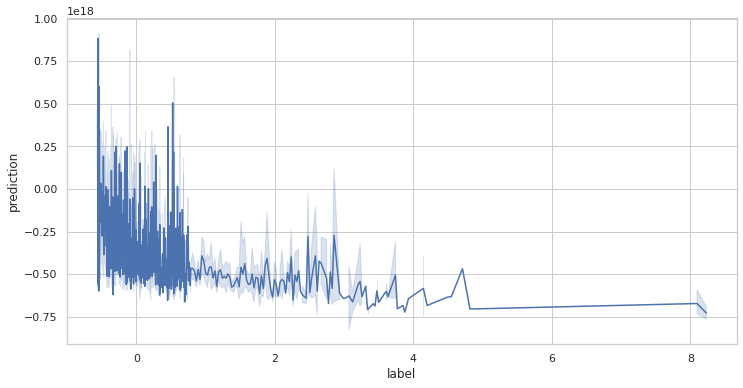

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df, x="label", y="prediction", legend='full')